In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic sine wave data with anomalies

In [2]:
def generate_series(size=300):
    x = np.linspace(0, 50, size)
    y = np.sin(x) + np.random.normal(scale=0.1, size=size)
    y[80:85] += 3  # Inject anomaly
    y[180:185] -= 3
    return y.astype(np.float32)
 
series = generate_series()

# Normalize

In [3]:
series = (series - np.mean(series)) / np.std(series)

# Create sequences

In [4]:
def create_sequences(series, window=24):
    X = []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
    return np.array(X)[..., np.newaxis]  # Add channel dim
 
window_size = 24
X = create_sequences(series, window=window_size)

# Split into training and test sets

In [5]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]

# Build LSTM Autoencoder

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, 1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.RepeatVector(window_size),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
 
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, X_train, epochs=10, verbose=0)

# Predict and calculate reconstruction error

In [7]:
X_pred = model.predict(X_test)
mse = np.mean(np.square(X_test - X_pred), axis=(1, 2))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


# Define anomaly threshold

In [8]:
threshold = np.percentile(mse, 95)

# Flag anomalies

In [9]:
anomalies = mse > threshold
anomaly_points = np.where(anomalies)[0] + train_size + window_size

# Plot results

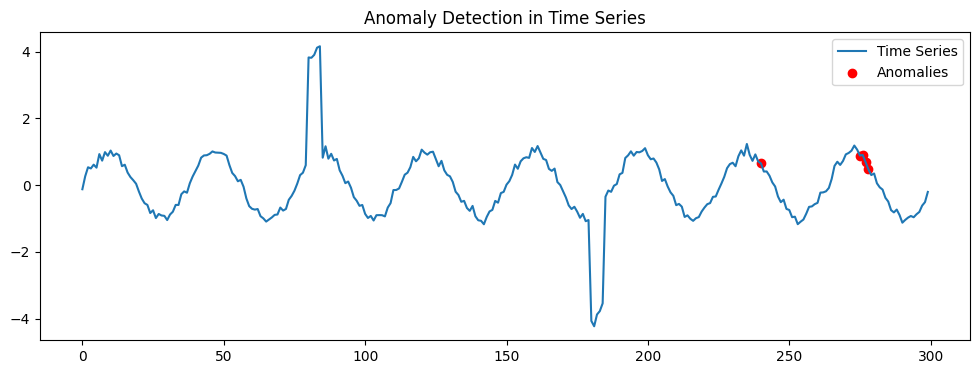

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(series, label="Time Series")
plt.scatter(anomaly_points, series[anomaly_points], color='red', label="Anomalies")
plt.title("Anomaly Detection in Time Series")
plt.legend()
plt.show()